# Notebook description
<!---define operatorname var-->
$\DeclareMathOperator{\Var}{Var}$
<!---define operatorname var-->This notebook compares Poisson vs periodic spike train encoding. We use the SNR and the latency as specifications.

Specifications:
 - $SNR=20$ or equivalently $NSR=.05$ or that we have a $5\%$ error.
 - Latency = $.01$s = $10$ms

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
<h2>Filtered Poisson spike train statistics</h2>

\begin{align*}
E[X] &= \lambda \\
\operatorname{Var}(X) &= \frac{\lambda}{2\tau} \\
SNR &= \sqrt{2\lambda\tau} \\
\end{align*}
</div>

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
<h2>Filtered periodic spike train statistics</h2>

$$
E[X] = \lambda
$$

<br>

\begin{align*}
\operatorname{Var}(X) &= \lambda^2\left(\frac{1}{2\lambda\tau}\coth\left(\frac{1}{2\lambda\tau}\right)-1\right) \\
\operatorname{Var}(X) &\approx \frac{1}{12\tau^2} & \text{at high }\lambda\tau \\
\end{align*}

<br>

\begin{align*}
SNR &= \frac{1}{\sqrt{\frac{1}{2\lambda\tau}\coth\left(\frac{1}{2\lambda\tau}\right)-1}} \\
SNR &\approx \sqrt{12}(\lambda\tau) & \text{at high }\lambda\tau\\
\end{align*}

</div>

In [1]:
import numpy as np
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('axes', labelsize=20)

In [2]:
def p_snr(lam, tau):
    return np.sqrt(2.*lam*tau)

def u_snr(lam, tau):
    return 1./np.sqrt(1./(2.*lam*tau)*(1.+np.exp(-1./lam/tau))/(1.-np.exp(-1./lam/tau))-1)

def get_u_lam(snr, tau, approx=False):
    if approx:
        lam = snr / np.sqrt(12) / tau
    else:
        ret = fsolve(lambda x: u_snr(x, tau) - snr, 1./tau)
        lam = ret[0]
        assert np.isclose(u_snr(lam, tau), snr), '%f' % lam
    return lam

def get_p_lam(snr, tau):
    lam = snr**2/2./tau
    return lam

First let's check the required Poisson and periodic spike rates given the specified SNR and latency. That is, if we simply encoded a value using a Poisson or periodic spike train, what rate would we need to spike at to meet the SNR and latency spec? This is equivalent to assuming we're using a single neuron to encode our value.

In [3]:
snr = 20.
tau = .01

lam_p = get_p_lam(snr, tau)
lam_u_approx = get_u_lam(snr, tau, approx=True)
lam_u = get_u_lam(snr, tau)

print 'Poisson spike encoding requires %.0f spks/s' % lam_p
print 'Periodic spike encoding requires %.0f spks/s (approx)' % lam_u_approx
print 'Periodic spike encoding requires %.0f spks/s' % lam_u

Poisson spike encoding requires 20000 spks/s
Periodic spike encoding requires 577 spks/s (approx)
Periodic spike encoding requires 577 spks/s


The periodic spike process encoding requires approximately a $40$-fold lower rate than the Poisson spike process encoding.

Note that applying a decode weight $d$ to a single neuron does not change the $SNR$ because $E[dX]=dE[X]$ and $\Var(dX)=d^2\Var(X)$ so $SNR(dX) = \frac{E[dX]}{\sqrt{\Var(dX)}} = \frac{dE[X]}{d\sqrt{\Var(X)}}=SNR(X)$.

Next, we sweep the firing rate (for constant $\tau$) and see how the SNR changes for the Poisson vs periodic processes. $\lambda\tau$ is the number of spikes in a $\tau$-long window.

# Low $\lambda\tau$ SNR

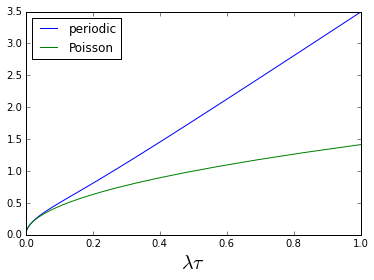

In [4]:
lam = np.logspace(-6, np.log10(1./tau), 100)
plt.plot(lam*tau, u_snr(lam, tau), label='periodic')
plt.plot(lam*tau, p_snr(lam, tau), label='Poisson')
plt.xlim(0, max(lam)*tau)
plt.legend(loc='best')
plt.xlabel(r'$\lambda\tau$');

We see that for for less than $0.1$ spikes per $\tau$ (i.e. $\lambda\tau<.1$), the $SNR$ looks approximately the same for Poisson and periodic spike processes. For $\lambda\tau>.1$, the $SNR$ diverges between the Poisson and periodic spike processes.

# High $\lambda\tau$ SNR

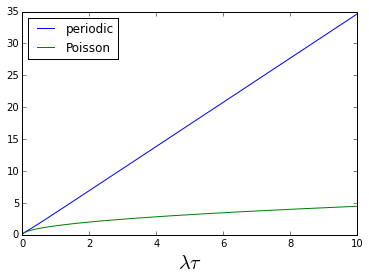

In [5]:
# lam = np.linspace(0, .01/tau, 100)[1:]
lam = np.logspace(-6, np.log10(10./tau), 100)
plt.plot(lam*tau, u_snr(lam, tau), label='periodic')
plt.plot(lam*tau, p_snr(lam, tau), label='Poisson')
plt.legend(loc='best')
plt.xlabel(r'$\lambda\tau$');

The high $\lambda\tau$ plot shows the trend of diverging Poisson and periodic $SNR$ for high $\lambda\tau$.

# Using multiple neurons

In practice, we'll never use a single neuron because we need a diversity of tuning curves to approximate arbitrary functions. Let's say we use $N$ neurons weighted by decode weights $d_i$ and take the sum of their spike trains as encoding the signal.

Now, assuming the filtered processes are uncorrelated,

$$
X = d_1X_1 + d_2X_2 + \ldots + d_NX_N
$$

$$
E[X] = d_1E[X_1] + d_2E[X_2] + \ldots + d_NE[X_N]
$$

$$
\Var(X) = d_1^2\Var(X_1) + d_2^2\Var(X_2) + \ldots + d_N^2\Var(X_N)
$$

$$
SNR = \frac{d_1E[X_1] + d_2E[X_2] + \ldots + d_NE[X_N]}{\sqrt{d_1^2\Var(X_1) + d_2^2\Var(X_2) + \ldots + d_N^2\Var(X_N)}}
$$

If we assume that $d_i=d$ are all the same, then they can be factored out and don't affect the $SNR$.

\begin{align*}
SNR &= \frac{d(E[X_1] + E[X_2] + \ldots + E[X_N])}
    {\sqrt{d^2(\Var(X_1) + \Var(X_2) + \ldots + \Var(X_N))}} \\
 &= \frac{E[X_1] + E[X_2] + \ldots + E[X_N]}
    {\sqrt{\Var(X_1) + \Var(X_2) + \ldots + \Var(X_N)}} \\
\end{align*}

Further, if we assume that the neurons are spiking at the same rate, 

\begin{align*}
SNR &= \frac{NE[X_i]}{\sqrt{N\Var(X_i)}} \\
 &= \sqrt{N}\frac{E[X_i]}{\sqrt{\Var(X_i)} } \\
 &= \sqrt{N}SNR(X_i) \\
SNR(X_i) &= \frac{SNR}{\sqrt{N}}
\end{align*}

As we add neurons, how fast must the neurons spike to maintain the same SNR?

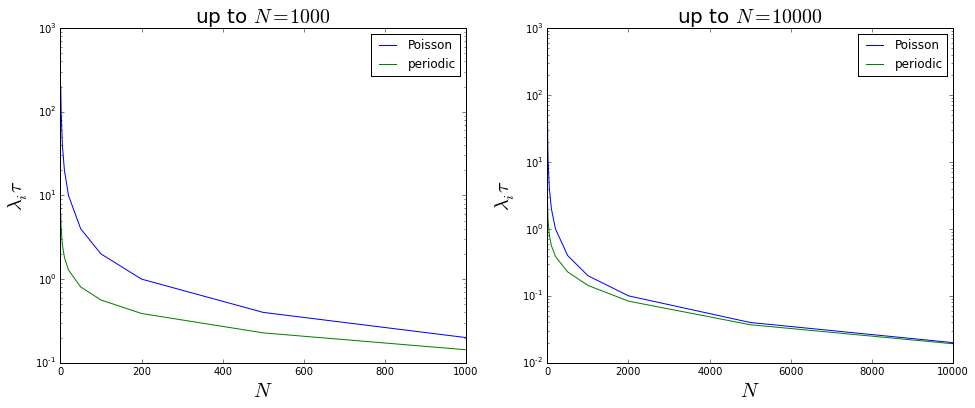

In [6]:
Ns = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
lam_p = np.zeros(len(Ns))
lam_u = np.zeros(len(Ns))

for idx, N in enumerate(Ns):
    snr_i = snr/np.sqrt(N)
    lam_p[idx] = get_p_lam(snr_i, tau)
    lam_u[idx] = get_u_lam(snr_i, tau)

clip_idx = Ns<=1000
fig, axs= plt.subplots(ncols=2, figsize=(16, 6))
axs[0].semilogy(Ns[clip_idx], lam_p[clip_idx]*tau, label='Poisson')
axs[0].semilogy(Ns[clip_idx], lam_u[clip_idx]*tau, label='periodic')
axs[0].legend(loc='best')
axs[0].set_xlabel(r'$N$')
axs[0].set_ylabel(r'$\lambda_i\tau$')
axs[0].set_title(r'up to $N=1000$', fontsize=20)

axs[1].semilogy(Ns, lam_p*tau, label='Poisson')
axs[1].semilogy(Ns, lam_u*tau, label='periodic')
axs[1].legend(loc='best')
axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$\lambda_i\tau$')
axs[1].set_title(r'up to $N=10000$', fontsize=20)

As the number of neurons gets very high, $\lambda_i\tau$ decreases below $0.1$, and required spike rates of the individual Poisson and periodic processes converge. 

Let's also look at the total spike rate of the population of the neurons. 

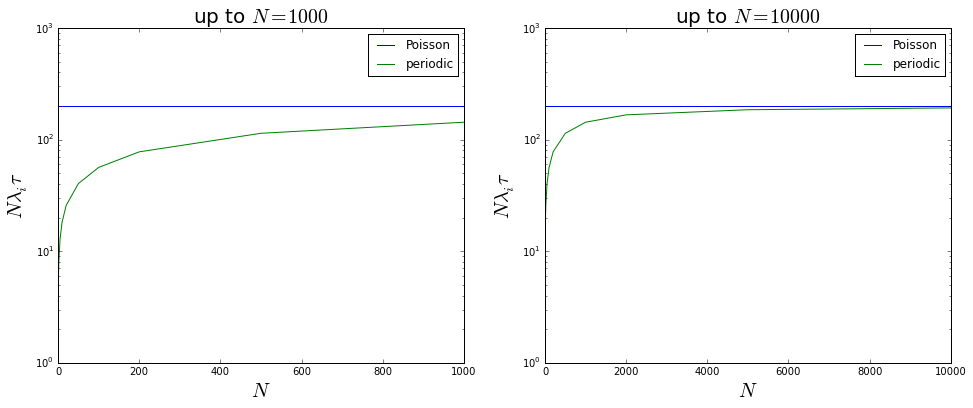

In [7]:
fig, axs= plt.subplots(ncols=2, figsize=(16, 6))
axs[0].semilogy(Ns[clip_idx], Ns[clip_idx]*lam_p[clip_idx]*tau, label='Poisson')
axs[0].semilogy(Ns[clip_idx], Ns[clip_idx]*lam_u[clip_idx]*tau, label='periodic')
axs[0].legend(loc='best')
axs[0].set_xlabel(r'$N$')
axs[0].set_ylabel(r'$N\lambda_i\tau$')
axs[0].set_title(r'up to $N=1000$', fontsize=20)

axs[1].semilogy(Ns, Ns*lam_p*tau, label='Poisson')
axs[1].semilogy(Ns, Ns*lam_u*tau, label='periodic')
axs[1].legend(loc='best')
axs[1].set_xlabel(r'$N$')
axs[1].set_ylabel(r'$N\lambda_i\tau$')
axs[1].set_title(r'up to $N=10000$', fontsize=20);

The Poisson neurons require a constant spike rate as would be expected. The periodic spiking neurons require a higher total spike rate with more neurons.